## Univariate output with lag=10
### Using spread of 20-year and 3-month

### Contents
- [Preprocessing](#Preprocessing)
- [Logistics Regression](#Logistics-Regression)
- [Decision Tree](#Decision-Tree)
- [SVC](#SVC)

### Preprocessing

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [2]:
 warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('20_0_T10.csv')

In [4]:
data_temp=df.values
print(np.shape(data_temp))
print(sum(df.LABEL == True))

(2234, 15)
340


In [5]:
from sklearn.model_selection import train_test_split

X, y = data_temp[:, 1:], data_temp[:, 0]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
sum(y_test)

102.0

In [6]:
sum(y_train)

238.0

In [7]:
sum(y_test)

102.0

In [8]:
# upsampling
print('Number of recession samples before:',X_train[y_train==1].shape[0])
print('Number of normal samples before:',X_train[y_train==0].shape[0])
X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1],
                                   replace=True,
                                   n_samples = X_train[y_train==0].shape[0],
                                   random_state = 1)
print("Number of recession samples after:", X_upsampled.shape[0])

Number of recession samples before: 238
Number of normal samples before: 1325
Number of recession samples after: 1325


In [9]:
X_train_bal = np.vstack((X_train[y_train==0], X_upsampled))

In [10]:
y_train_bal = np.hstack((y_train[y_train==0], y_upsampled))

In [11]:
print(X_train_bal.shape)
print(y_train_bal.shape)

(2650, 14)
(2650,)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_bal)
X_test_std = stdsc.transform(X_test)

### Logistics Regression

In [14]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_std, y_train_bal)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
scores = cross_val_score(estimator = lr,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.8203125  0.84671533 0.83206107 0.82656827 0.85501859 0.76156584
 0.84782609 0.8125     0.83895131 0.83870968]
CV accuracy: 0.828 +/- 0.025


In [19]:
y_pred_lr2 = lr.predict(X_test_std)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_lr2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[450 119]
 [ 19  83]]
Precision: 0.411
Recall: 0.814
F1: 0.546


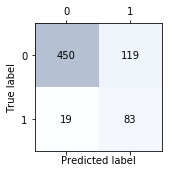

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

### Decision Tree

In [22]:
## Tree Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=3, scoring='f1', n_jobs=-1)
gs=grid.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7020761479678095
{'max_depth': 9}


In [23]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=9, 
                              random_state=1)


In [24]:
scores = cross_val_score(estimator = tree,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.97777778 0.94964029 0.95652174 0.97777778 0.95652174 0.93333333
 0.95340502 0.93818182 0.96028881 0.94927536]
CV accuracy: 0.955 +/- 0.014


In [25]:
tree.fit(X_train_bal, y_train_bal)
y_pred_tree2 = tree.predict(X_test)
print('Train Accuracy: %.3f' % tree.score(X_train_bal, y_train_bal))
print('Test Accuracy: %.3f' % tree.score(X_test, y_test))#忽略该块程序即可，为了可视化tree没用pipeline

Train Accuracy: 0.967
Test Accuracy: 0.891


In [26]:
#tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_tree2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[519  50]
 [ 23  79]]
Precision: 0.612
Recall: 0.775
F1: 0.684


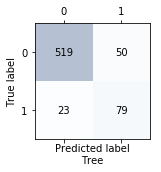

In [27]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nTree')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('cm_20_0', dpi=300)
plt.show()

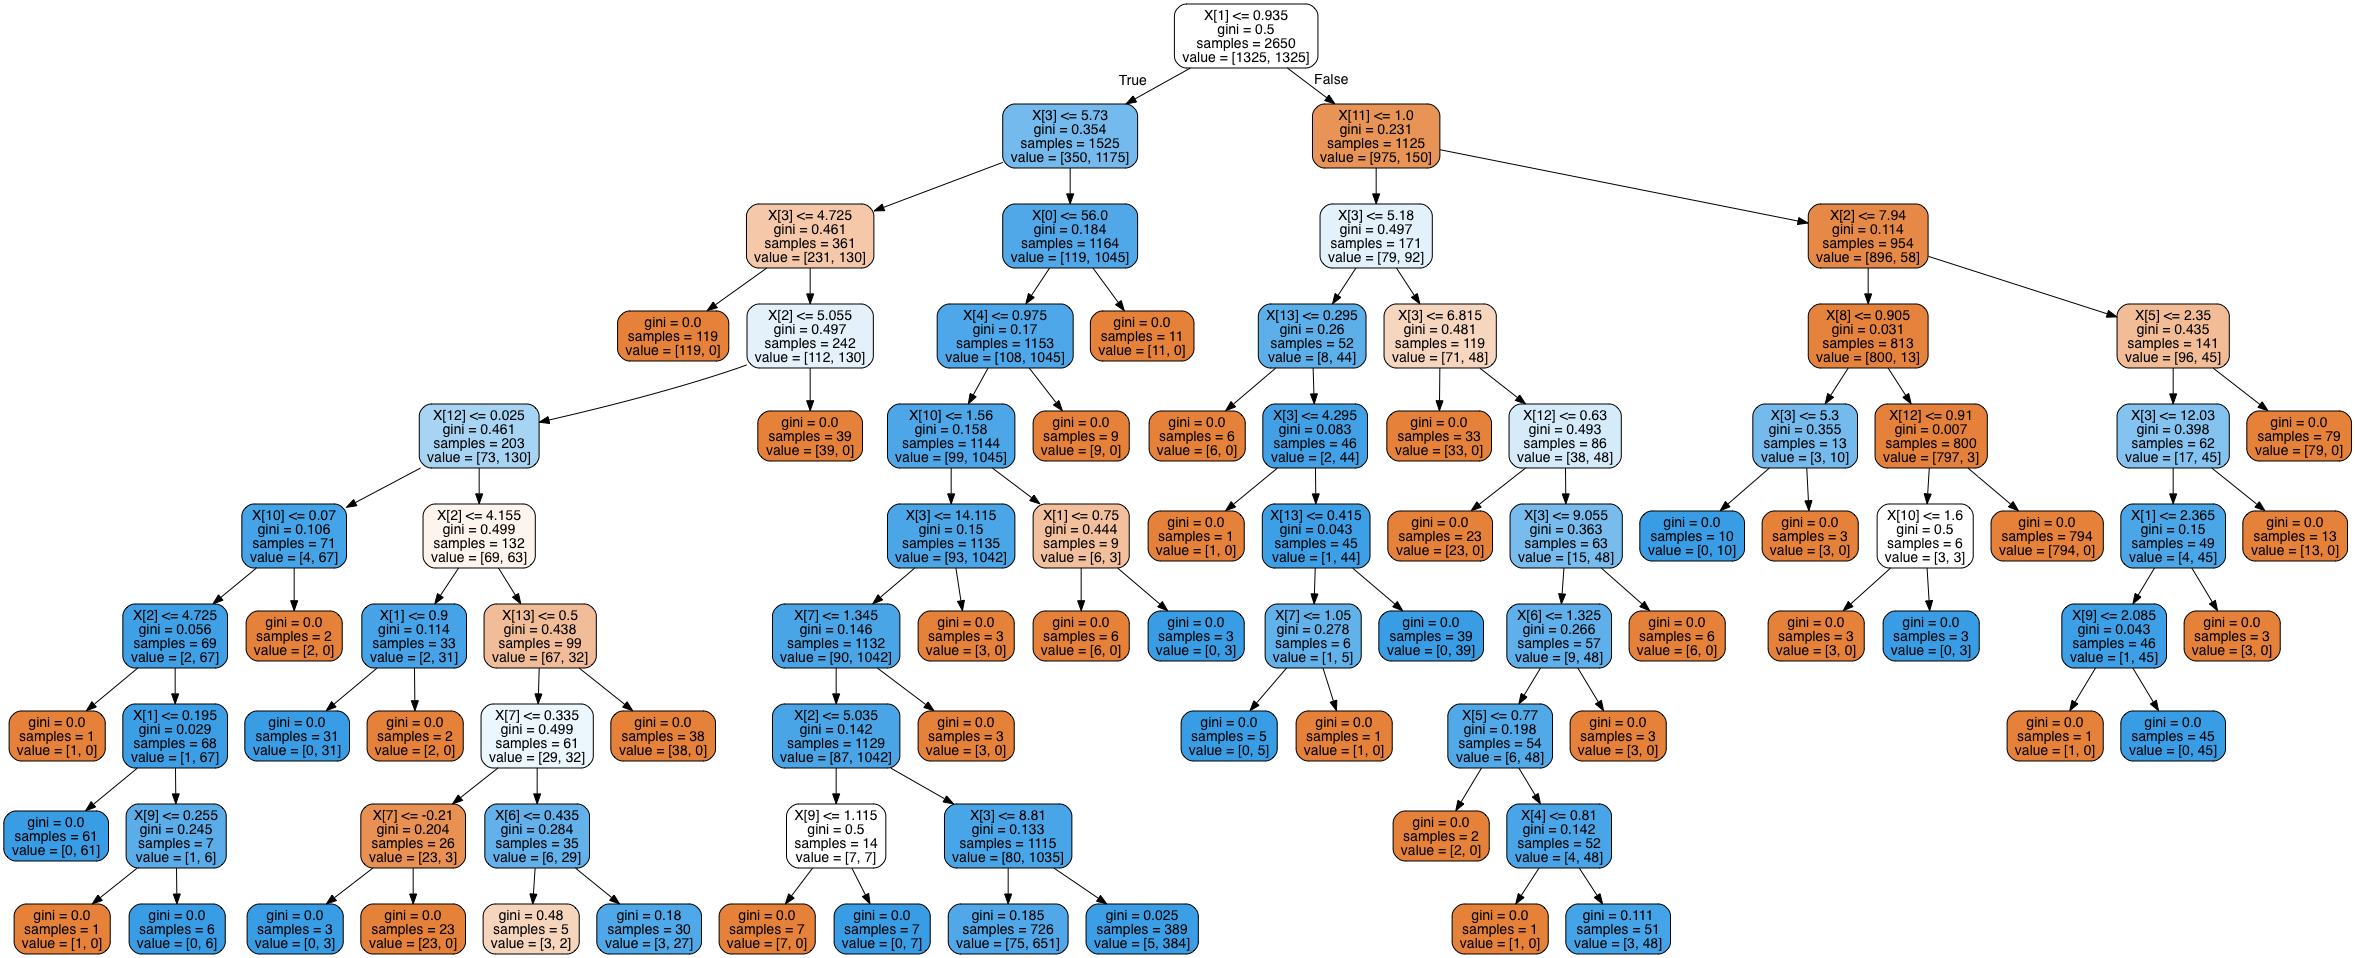

In [28]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           #class_names=['Setosa', 
                            #            'Versicolor',
                            #            'Virginica'],
                          # feature_names=['petal length', 
                          #                'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree20_0_T10.png') 

from IPython.display import Image
Image(filename='tree20_0_T10.png', width=600) 

#X[1]is the spread of 20y-3m without lag
#X[3]is the the yied of 20y bond without lag
#X[11]is the spread of 20y-3m without lag=8

### SVC

In [29]:
svm = SVC(kernel='rbf', random_state=1, C=0.01, gamma=0.5,probability=True) #gamma
svm.fit(X_train_std, y_train_bal)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
scores = cross_val_score(estimator = svm,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.77876106 0.75862069 0.7394958  0.72527473 0.75       0.34883721
 0.47513812 0.53807107 0.49450549 0.39766082]
CV accuracy: 0.601 +/- 0.158


In [31]:
y_pred_svc2 = svm.predict(X_test_std)

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_svc2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[424 145]
 [  7  95]]
Precision: 0.396
Recall: 0.931
F1: 0.556


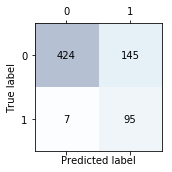

In [33]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()